In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler




x_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('X_test_final.csv')

pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer


In [2]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

def scale_features_exclude_id(dataset, id_column):
    # Extract the ID column and save it
    ids = dataset[id_column]
    
    # Drop the ID column before scaling
    dataset_to_scale = dataset.drop(id_column, axis=1)
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Fit and transform the data without the ID column
    scaled_data = scaler.fit_transform(dataset_to_scale)
    
    # Create a DataFrame from the scaled data
    scaled_df = pd.DataFrame(scaled_data, columns=dataset_to_scale.columns)
    
    # Reinsert the ID column
    scaled_df[id_column] = ids.values
    
    # Reorder columns to place ID column at its original location
    columns = [id_column] + [col for col in scaled_df.columns if col != id_column]
    scaled_df = scaled_df[columns]
    
    return scaled_df

x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)

x_train_imputed['DE_GAS_COAL_INTERACTION'] = x_train_imputed['DE_GAS'] * x_train_imputed['DE_COAL']
x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_train_imputed['FR_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_NET_EXPORT'].cumsum()
x_train_imputed['FR_CONSUMPTION_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_CONSUMPTION'].cumsum()
x_train_imputed['DE_CONSUMPTION_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_CONSUMPTION'].cumsum()
x_test_imputed['GAS_COAL_INTERACTION'] = x_test_imputed['DE_GAS'] * x_test_imputed['DE_COAL']

x_train_imputed = scale_features_exclude_id(x_train_imputed, 'DAY_ID')
x_test_imputed = scale_features_exclude_id(x_test_imputed, 'DAY_ID')

In [3]:
x_train_imputed.head()

,DAY_ID,ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,DE_GAS_COAL_INTERACTION,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_CONSUMPTION_cumsum,DE_CONSUMPTION_cumsum
0,206.0,-0.030364,-0.322857,-0.443488,-0.485207,0.485207,1.071028,0.723596,-1.071028,-0.723596,-0.399410,-0.671802,1.033005,1.429527,1.539319,0.096641,1.305529,0.265854,-0.135517,0.593795,-0.676524,-0.561718,1.373826,0.652048,-0.324738,-0.145675,-0.572836,-0.880001,-0.411341,-1.113070,-0.053275,0.255982,0.060791,-0.075534,-0.869242,0.869242,0.135522,0.800184,0.503731,-0.270405,-0.367669
1,501.0,1.580173,-0.668227,-1.070463,0.121136,-0.121136,-0.379181,-0.985283,0.379181,0.985283,-0.712934,0.035225,-0.042576,-0.647535,-0.321772,-0.863111,-1.567949,-1.803692,1.627541,2.436614,-0.170940,-0.425377,0.122845,-0.548748,-1.148970,-1.260002,-0.781465,1.349790,0.665097,0.472314,1.881258,-0.653560,-0.014136,-0.519802,-0.869242,0.869242,-0.177892,-0.150114,-0.608582,-0.693418,-0.592145
2,687.0,1.377844,1.437334,2.175600,1.203569,-1.203569,-0.430784,-1.502294,0.430784,1.502294,1.848693,1.906013,2.014869,2.394545,-0.594840,0.636875,-1.583876,1.225802,-1.273716,-0.907498,-0.418386,-0.453879,0.854386,1.486102,2.344758,-0.467172,-0.336031,0.297919,0.335065,0.732739,0.128718,0.435437,0.659515,0.113308,-0.869242,0.869242,3.098533,-0.183928,-0.945106,1.496668,0.776382
3,720.0,-1.255667,-2.095654,-0.902555,-0.726996,0.726996,-0.057185,0.602128,0.057185,-0.602128,-0.344604,-0.221100,-1.581446,-0.694716,-0.834109,1.148775,0.291125,-1.185154,1.406974,-0.041927,-0.147041,-0.026527,-2.387277,-1.484376,-0.918821,-1.129052,-0.525298,-0.599089,-0.365912,0.381304,-0.414841,0.777771,-0.346290,0.904558,1.150428,-1.150428,-0.783649,0.060885,0.424667,-0.580133,-1.519913
4,818.0,0.045712,-0.421331,-0.649847,-0.815597,0.815597,0.733009,1.002332,-0.733009,-1.002332,-0.637725,-0.701703,1.343639,0.315321,-0.706815,-0.852588,0.512776,0.646885,0.417783,0.106950,-0.866000,-0.809856,1.163141,0.587372,-0.415813,-0.530595,-0.444400,-1.166620,-1.116718,0.658499,0.756317,0.170387,1.417389,2.307172,-0.869242,0.869242,0.058869,0.578686,0.685161,-0.409633,-0.431673


In [4]:
x_train_imputed.drop('ID', axis = 1, inplace = True)

y_train.drop('ID', axis = 1, inplace = True)


In [5]:
x_train_imputed.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,DE_GAS_COAL_INTERACTION,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_CONSUMPTION_cumsum,DE_CONSUMPTION_cumsum
0,206.0,-0.322857,-0.443488,-0.485207,0.485207,1.071028,0.723596,-1.071028,-0.723596,-0.399410,-0.671802,1.033005,1.429527,1.539319,0.096641,1.305529,0.265854,-0.135517,0.593795,-0.676524,-0.561718,1.373826,0.652048,-0.324738,-0.145675,-0.572836,-0.880001,-0.411341,-1.113070,-0.053275,0.255982,0.060791,-0.075534,-0.869242,0.869242,0.135522,0.800184,0.503731,-0.270405,-0.367669
1,501.0,-0.668227,-1.070463,0.121136,-0.121136,-0.379181,-0.985283,0.379181,0.985283,-0.712934,0.035225,-0.042576,-0.647535,-0.321772,-0.863111,-1.567949,-1.803692,1.627541,2.436614,-0.170940,-0.425377,0.122845,-0.548748,-1.148970,-1.260002,-0.781465,1.349790,0.665097,0.472314,1.881258,-0.653560,-0.014136,-0.519802,-0.869242,0.869242,-0.177892,-0.150114,-0.608582,-0.693418,-0.592145
2,687.0,1.437334,2.175600,1.203569,-1.203569,-0.430784,-1.502294,0.430784,1.502294,1.848693,1.906013,2.014869,2.394545,-0.594840,0.636875,-1.583876,1.225802,-1.273716,-0.907498,-0.418386,-0.453879,0.854386,1.486102,2.344758,-0.467172,-0.336031,0.297919,0.335065,0.732739,0.128718,0.435437,0.659515,0.113308,-0.869242,0.869242,3.098533,-0.183928,-0.945106,1.496668,0.776382
3,720.0,-2.095654,-0.902555,-0.726996,0.726996,-0.057185,0.602128,0.057185,-0.602128,-0.344604,-0.221100,-1.581446,-0.694716,-0.834109,1.148775,0.291125,-1.185154,1.406974,-0.041927,-0.147041,-0.026527,-2.387277,-1.484376,-0.918821,-1.129052,-0.525298,-0.599089,-0.365912,0.381304,-0.414841,0.777771,-0.346290,0.904558,1.150428,-1.150428,-0.783649,0.060885,0.424667,-0.580133,-1.519913
4,818.0,-0.421331,-0.649847,-0.815597,0.815597,0.733009,1.002332,-0.733009,-1.002332,-0.637725,-0.701703,1.343639,0.315321,-0.706815,-0.852588,0.512776,0.646885,0.417783,0.106950,-0.866000,-0.809856,1.163141,0.587372,-0.415813,-0.530595,-0.444400,-1.166620,-1.116718,0.658499,0.756317,0.170387,1.417389,2.307172,-0.869242,0.869242,0.058869,0.578686,0.685161,-0.409633,-0.431673


In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the DecisionTreeRegressor with a random state for reproducibility
dt_reg = DecisionTreeRegressor(random_state=42)

# Compute the cross-validated MSE
mse_valid_dt = cross_val_score(dt_reg, x_train_imputed, y_train, scoring='neg_mean_squared_error', cv=5)
average_mse_dt = -np.mean(mse_valid_dt)
print(f'Average MSE for Decision Tree: {average_mse_dt}')

# Compute the cross-validated MAE
mae_scores_dt = cross_val_score(dt_reg, x_train_imputed, y_train, scoring='neg_mean_absolute_error', cv=5)
average_mae_dt = -np.mean(mae_scores_dt)
print(f'Average MAE for Decision Tree: {average_mae_dt}')


Average MSE for Decision Tree: 2.1104887338261342
Average MAE for Decision Tree: 0.8951678653539805


In [7]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

# Initialize the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model to your data
dt_reg.fit(x_train_imputed, y_train)

# Get feature importances
feature_importances = dt_reg.feature_importances_

# Get the feature names
feature_names = x_train_imputed.columns.tolist()

sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Reset the index of the DataFrame
feature_importance_df.reset_index(drop=True, inplace=True)

print("Feature Importances (Sorted):")
print(feature_importance_df)


Feature Importances (Sorted):
                    Feature  Importance
0                DE_WINDPOW    0.084994
1                   GAS_RET    0.073196
2     FR_CONSUMPTION_cumsum    0.067548
3                    DAY_ID    0.064146
4                  FR_SOLAR    0.053759
5            DE_CONSUMPTION    0.044703
6                  DE_SOLAR    0.042946
7                    DE_GAS    0.042227
8                FR_WINDPOW    0.034956
9      DE_NET_EXPORT_cumsum    0.031747
10               CARBON_RET    0.030869
11     FR_NET_EXPORT_cumsum    0.028661
12    DE_CONSUMPTION_cumsum    0.026487
13                   FR_GAS    0.024100
14                 DE_HYDRO    0.023917
15                  FR_COAL    0.021310
16                 FR_HYDRO    0.020904
17                  FR_WIND    0.020236
18                  FR_RAIN    0.019963
19                  DE_WIND    0.018182
20           FR_CONSUMPTION    0.016685
21                  DE_RAIN    0.016005
22               DE_NUCLEAR    0.015710
23        

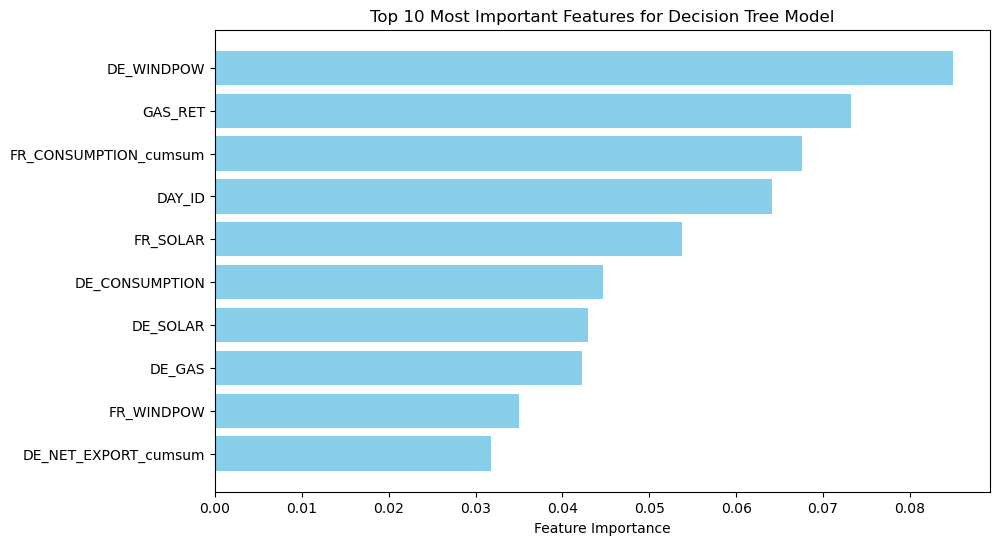

In [8]:
import matplotlib.pyplot as plt

# Assuming 'feature_importance_df' is your DataFrame with feature importances sorted in descending order
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar chart for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features for Decision Tree Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


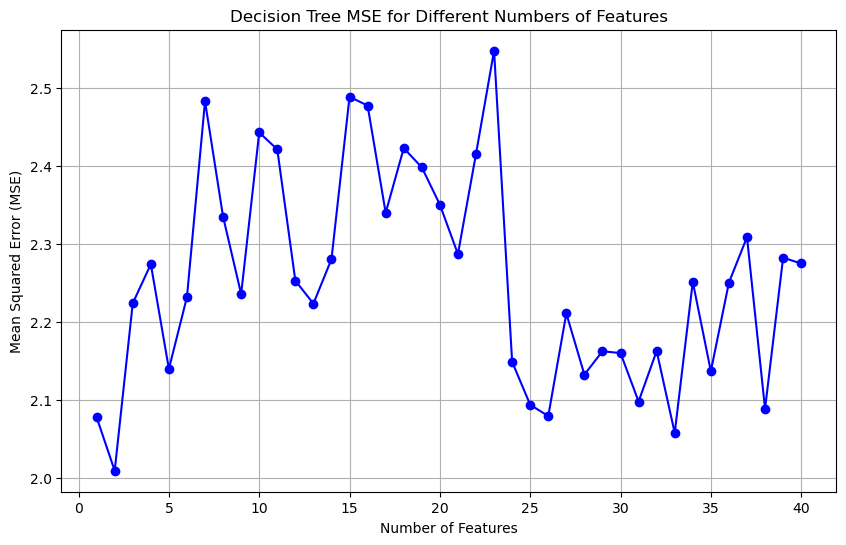

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train_imputed is already defined and contains the imputed training data

# Initialize an empty list to store the mean squared errors for each k number of features
mse_scores_per_k = []

# Initialize the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Loop over the range of number of features
for k in range(1, len(x_train_imputed.columns) + 1):
    # Select the top k features based on previously computed feature importances
    selected_features = [feature[0] for feature in sorted_importances[:k]]
    
    # Compute the cross-validated MSE
    mse_scores = cross_val_score(dt_reg, x_train_imputed[selected_features], y_train, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

# Plot the MSE scores for each number of top features used
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(x_train_imputed.columns) + 1), mse_scores_per_k, marker='o', linestyle='-', color='b')
plt.title('Decision Tree MSE for Different Numbers of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()



In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid specific to DecisionTreeRegressor
param_grid_dt = {
    'max_depth': [None] + list(range(1, 20)),  # None means no limit on depth
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': ['sqrt', 'log2', None]  # None means max_features=n_features
}

# Initialize the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Setup RandomizedSearchCV for DecisionTreeRegressor
random_search_dt = RandomizedSearchCV(
    dt_reg,
    param_distributions=param_grid_dt,
    n_iter=80,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search_dt.fit(x_train_imputed, y_train)

# Print the best parameters and the mean cross-validated score of the best estimator
print("Best Parameters:", random_search_dt.best_params_)
best_dt_model = random_search_dt.best_estimator_
mean_cv_score_dt = random_search_dt.best_score_
print(f'Mean Cross-Validated Score: {-mean_cv_score_dt}')

Best Parameters: {'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': 'log2', 'max_depth': 2}
Mean Cross-Validated Score: 1.0524764277366156


In [11]:
rs_df = pd.DataFrame(random_search_dt.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,split2_test_score,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,4,13,log2,2,-0.801969,-1.146295,-0.849548,-1.052476,1
1,5,3,log2,2,-0.802007,-1.146295,-0.849548,-1.060409,2
2,12,8,log2,3,-0.813511,-1.138368,-0.907891,-1.070547,3
3,3,13,log2,1,-0.832629,-1.121540,-0.865330,-1.072614,4
4,13,18,log2,1,-0.832629,-1.121540,-0.865330,-1.072614,4
5,11,11,None,1,-0.813008,-1.151674,-0.885216,-1.079267,6
6,9,14,sqrt,1,-0.862712,-1.133183,-0.865330,-1.081515,7
7,19,15,None,2,-0.812260,-1.209195,-0.898844,-1.095444,8
8,7,12,log2,5,-0.864858,-1.195831,-0.962586,-1.110951,9
9,3,11,None,3,-0.861080,-1.227291,-0.921772,-1.117896,10


In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from scipy.stats import spearmanr

# Assuming sorted_importances and x_train_imputed are defined as before
# and y_train is your target variable.

# Initialize the DecisionTreeRegressor
dt_reg_selected = DecisionTreeRegressor(random_state=42)

# Extract the top 8 features based on sorted importances from a previous model 
selected_features = [feature[0] for feature in sorted_importances[:9]]

# Perform cross-validated predictions with the Decision Tree using the selected features
y_pred_cv_dt = cross_val_predict(dt_reg_selected, x_train_imputed[selected_features], y_train, cv=5)

# Define the scorer function for Spearman correlation
def spearman_corr_scorer(y_true, y_pred):
    spearman_corr, _ = spearmanr(y_pred, y_true)
    return spearman_corr

# Calculate Spearman correlation for the entire cross-validated predictions with the Decision Tree
spearman_corr_cv_dt = spearman_corr_scorer(y_train, y_pred_cv_dt)

print(f'Average Spearman Correlation for Decision Tree: {spearman_corr_cv_dt}')


Average Spearman Correlation for Decision Tree: 0.07675920481939669


In [13]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)


x_train_imputed


,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR
0,1054.0,206.0,0.210099,-0.427458,-0.606523,0.606523,0.789557,0.692860,-0.789557,-0.692860,0.441238,-0.213766,0.740627,0.288782,2.209047,0.207838,0.709614,-0.190463,0.101766,1.248911,-0.573370,-0.269460,0.870344,0.626666,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445,0.0,1.0
1,2049.0,501.0,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,0.174773,0.426940,-0.170392,-0.762153,0.187964,-0.807112,-1.882740,-2.185961,1.987428,3.237380,-0.035514,-0.107350,-0.194308,-0.395469,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365,0.0,1.0
2,1924.0,687.0,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,2.351913,2.122241,1.572267,0.777053,-0.108578,0.779142,-1.897109,0.735137,-1.115583,-0.371039,-0.298755,-0.141239,0.428272,1.336625,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952,0.0,1.0
3,297.0,720.0,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,0.487818,0.194659,-1.473817,-0.786025,-0.368417,1.320483,-0.205547,-1.589554,1.751523,0.562944,-0.010090,0.366885,-2.330557,-1.191889,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948,1.0,0.0
4,1101.0,818.0,0.143807,-0.617038,-0.924990,0.924990,0.471847,0.990324,-0.471847,-0.990324,0.238693,-0.240862,1.003734,-0.274975,-0.230179,-0.795983,-0.005581,0.176935,0.693543,0.723587,-0.774941,-0.564498,0.691040,0.571613,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459.0,809.0,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,-1.450426,1.810665,1.388269,0.359723,-0.294001,-0.470809,1.708814,0.207266,0.712492,-1.325306,-0.855249,-0.057214,2.968535,0.790548,1.547782,0.509514,-0.077656,0.890049,0.260822,0.520315,-0.460030,-0.238427,0.876984,0.819520,1.320373,1.0,0.0
1490,1674.0,887.0,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,0.152146,1.972779,1.558300,0.561356,0.230746,-0.341147,2.957114,0.217922,0.926279,-1.222781,-0.923261,0.198857,0.789618,0.917482,1.358927,1.666252,-0.142641,0.539836,0.509007,0.838269,-1.079079,-1.071237,0.932633,-0.085690,0.356356,0.0,1.0
1491,748.0,1083.0,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,0.829568,2.108764,1.866399,1.072553,-0.180117,0.037892,0.277630,-1.833866,-0.964588,-0.626731,0.196789,-0.981718,0.303324,0.211422,1.493870,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152,1.0,0.0
1492,1454.0,1133.0,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,-1.210230,-0.003973,0.869742,-0.436935,-0.772801,-0.288150,1.447245,0.107706,-0.196405,0.619473,0.918251,0.378080,-0.973969,-0.828580,-0.137667,-0.184862,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812,0.0,1.0


In [14]:
x_train_imputed.sort_values(by = 'DAY_ID', inplace = True)

In [15]:
#Linearize the relationship of eolienne production relative to wind
x_train_imputed['FR_WIND_SQR'] = x_train_imputed['FR_WIND'] **(1/2)
x_train_imputed['DE_WIND_SQR'] = x_train_imputed['DE_WIND'] **(1/2)

x_train_imputed['FR_RAIN_CUBE'] = x_train_imputed['FR_RAIN']**(1/6)
x_train_imputed['DE_RAIN_CUBE'] = x_train_imputed['DE_RAIN']**(1/6)

x_train_imputed['FR_NON_RENEW_CONSUMPTION'] = x_train_imputed['FR_RESIDUAL_LOAD']/x_train_imputed['FR_CONSUMPTION']
x_train_imputed['DE_NON_RENEW_CONSUMPTION'] = x_train_imputed['DE_RESIDUAL_LOAD']/x_train_imputed['DE_CONSUMPTION']

x_train_imputed['FR_PERC_ELEC_TO_DE'] = x_train_imputed['FR_DE_EXCHANGE']/x_train_imputed['FR_NET_EXPORT']
x_train_imputed['DE_PERC_ELEC_TO_FR'] = x_train_imputed['DE_FR_EXCHANGE']/x_train_imputed['DE_NET_EXPORT']

x_train_imputed['FR_NON_RENEWABLE'] = x_train_imputed['FR_COAL']+ x_train_imputed['FR_GAS'] + x_train_imputed['FR_NUCLEAR']
x_train_imputed['FR_RENEWABLE'] = x_train_imputed['FR_HYDRO']+ x_train_imputed['FR_SOLAR'] + x_train_imputed['FR_WINDPOW']

x_train_imputed['DE_NON_RENEWABLE'] = x_train_imputed['FR_COAL']+ x_train_imputed['FR_GAS'] + x_train_imputed['FR_NUCLEAR'] + x_train_imputed['DE_LIGNITE']
x_train_imputed['DE_RENEWABLE'] = x_train_imputed['FR_HYDRO']+ x_train_imputed['FR_SOLAR'] + x_train_imputed['FR_WINDPOW']

In [19]:
y_train = pd.read_csv('y_train_ZAN5mwg.csv')

In [20]:
data_merged = pd.merge(x_train_imputed, y_train, on='ID')


In [21]:
data_merged

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,FR_WIND_SQR,DE_WIND_SQR,FR_RAIN_CUBE,DE_RAIN_CUBE,FR_NON_RENEW_CONSUMPTION,DE_NON_RENEW_CONSUMPTION,FR_PERC_ELEC_TO_DE,DE_PERC_ELEC_TO_FR,FR_NON_RENEWABLE,FR_RENEWABLE,DE_NON_RENEWABLE,DE_RENEWABLE,TARGET
0,1057.0,0.0,0.048418,-0.465067,-0.079296,0.079296,1.097725,0.650577,-1.097725,-0.650577,0.592572,-0.261565,0.534535,0.095197,1.312903,0.677089,0.470981,-0.357168,1.336885,1.185155,-0.726830,-0.874690,1.018472,0.261776,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,0.0,1.0,NaN,NaN,NaN,NaN,0.741197,5.406576,0.121886,-0.072237,-0.523535,0.987554,0.494937,0.987554,0.108953
1,1179.0,1.0,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,1.991028,0.660390,-0.786509,-0.681081,0.709616,0.830659,1.381575,0.136060,0.485975,-0.360309,-0.172140,1.090374,0.935387,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,0.0,1.0,NaN,NaN,NaN,NaN,0.993582,0.967311,-0.425564,0.817055,2.586095,1.023451,3.676469,1.023451,-0.063369
2,1327.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,0.0,1.0,NaN,NaN,NaN,NaN,0.810084,-5.782223,4.292403,1.020003,-0.687832,-0.742110,-1.159198,-0.742110,2.575976
3,111.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,0.0,NaN,NaN,NaN,NaN,0.810084,-5.782223,4.292403,1.020003,-0.687832,-0.742110,-1.159198,-0.742110,0.861270
4,2016.0,3.0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,0.069297,-0.635452,-0.718729,1.994144,-0.383690,-2.002323,-1.579208,1.527633,2.986527,-1.142488,-0.718643,-0.169336,0.275487,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,0.0,1.0,0.699035,0.494832,NaN,NaN,1.026070,-2.045648,-1.718117,0.558864,-2.228639,1.884194,-2.397975,1.884194,0.068905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,1987.0,1212.0,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,0.625656,-0.491812,-0.776785,-0.441138,-0.906285,-1.885215,-1.434474,1.859448,1.589641,-0.245558,-0.266687,-0.159332,-0.623925,-0.589767,-0.039379,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,0.0,1.0,1.060166,1.165423,NaN,NaN,1.133066,13.534238,-0.342501,1.961438,-1.585603,0.416669,-1.744935,0.416669,-0.425474
1490,771.0,1212.0,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,0.625656,-0.491812,-0.776785,-0.441138,-0.906285,-1.885215,-1.434474,1.859448,1.589641,-0.245558,-0.266687,-0.159332,-0.623925,-0.589767,-0.039379,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,1.0,0.0,1.060166,1.165423,NaN,NaN,1.133066,13.534238,-0.342501,1.961438,-1.585603,0.416669,-1.744935,0.416669,-0.144320
1491,472.0,1213.0,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,0.069222,1.781433,1.549682,-0.451947,-0.291751,-0.749000,1.933776,0.142984,0.258724,-0.994097,-

In [22]:
from sklearn.impute import KNNImputer

def preprocessing(dataset):
    # Fill null values with a placeholder value
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns

    # Replace the placeholder value with NaN
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)

    # Initialize and fit KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    imputed_data = imputer.fit_transform(dataset_filled)

    return pd.DataFrame(imputed_data, columns=columns_to_impute)

data_train_imputed = preprocessing(data_merged)

In [23]:
data_train_imputed

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,FR_WIND_SQR,DE_WIND_SQR,FR_RAIN_CUBE,DE_RAIN_CUBE,FR_NON_RENEW_CONSUMPTION,DE_NON_RENEW_CONSUMPTION,FR_PERC_ELEC_TO_DE,DE_PERC_ELEC_TO_FR,FR_NON_RENEWABLE,FR_RENEWABLE,DE_NON_RENEWABLE,DE_RENEWABLE,TARGET
0,1057.0,0.0,0.048418,-0.465067,-0.079296,0.079296,1.097725,0.650577,-1.097725,-0.650577,0.592572,-0.261565,0.534535,0.095197,1.312903,0.677089,0.470981,-0.357168,1.336885,1.185155,-0.726830,-0.874690,1.018472,0.261776,-0.344706,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,0.0,1.0,0.803815,0.949520,0.829755,0.926541,0.741197,5.406576,0.121886,-0.072237,-0.523535,0.987554,0.494937,0.987554,0.108953
1,1179.0,1.0,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,1.111008,1.991028,0.660390,-0.786509,-0.681081,0.709616,0.830659,1.381575,0.136060,0.485975,-0.360309,-0.172140,1.090374,0.935387,1.214288,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,0.0,1.0,0.686160,0.540636,0.796426,0.937851,0.993582,0.967311,-0.425564,0.817055,2.586095,1.023451,3.676469,1.023451,-0.063369
2,1327.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,0.0,1.0,0.482855,0.570350,0.792139,1.050423,0.810084,-5.782223,4.292403,1.020003,-0.687832,-0.742110,-1.159198,-0.742110,2.575976
3,111.0,2.0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,1.228079,0.458302,-0.247704,-0.766904,1.785758,-0.930172,0.064726,-0.379230,-0.187892,1.032412,-0.421844,-0.844350,-0.471366,0.398812,-0.540642,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,1.0,0.0,0.482855,0.403356,0.792139,1.050423,0.810084,-5.782223,4.292403,1.020003,-0.687832,-0.742110,-1.159198,-0.742110,0.861270
4,2016.0,3.0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,1.588542,0.069297,-0.635452,-0.718729,1.994144,-0.383690,-2.002323,-1.579208,1.527633,2.986527,-1.142488,-0.718643,-0.169336,0.275487,-0.856321,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,0.0,1.0,0.699035,0.494832,0.853344,0.958828,1.026070,-2.045648,-1.718117,0.558864,-2.228639,1.884194,-2.397975,1.884194,0.068905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,1987.0,1212.0,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,0.625656,-0.491812,-0.776785,-0.441138,-0.906285,-1.885215,-1.434474,1.859448,1.589641,-0.245558,-0.266687,-0.159332,-0.623925,-0.589767,-0.039379,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,0.0,1.0,1.060166,1.165423,0.931530,0.849131,1.133066,13.534238,-0.342501,1.961438,-1.585603,0.416669,-1.744935,0.416669,-0.425474
1490,771.0,1212.0,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,0.789824,0.231723,0.625656,-0.491812,-0.776785,-0.441138,-0.906285,-1.885215,-1.434474,1.859448,1.589641,-0.245558,-0.266687,-0.159332,-0.623925,-0.589767,-0.039379,-0.237434,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,1.0,0.0,1.060166,1.165423,0.931530,0.849131,1.133066,13.534238,-0.342501,1.961438,-1.585603,0.416669,-1.744935,0.416669,-0.144320
1491,472.0,1213.0,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.06

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint as sp_randint
import numpy as np

# Assuming 'data_train_imputed' is your DataFrame and includes 'TARGET'
X = data_train_imputed.drop(columns=['TARGET'])
y = data_train_imputed['TARGET']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid_rf = {
    'n_estimators': sp_randint(100, 1000),
    'max_depth': sp_randint(3, 20),
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'max_features': ['sqrt', 'log2', None]
}

rs_cv_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=10,  # Adjust based on computational budget
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit the model
rs_cv_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = rs_cv_rf.best_params_
print("Best Parameters:", best_params_rf)

# Initialize RandomForestRegressor with the best parameters
best_rf = RandomForestRegressor(**best_params_rf, random_state=42)

# Fit the model on the entire training dataset
best_rf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_rf = best_rf.predict(X_valid)

# Calculate RMSE for the predictions
rmse = np.sqrt(mean_squared_error(y_valid, y_pred_rf))
print(f'Validation RMSE: {rmse}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 445}
Validation RMSE: 0.9573810957681997


In [25]:
mse = mean_squared_error(y_valid, y_pred_rf)
mae = mean_absolute_error(y_valid, y_pred_rf)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"The Mean Squared Error is: {mse}")

r2_valid = r2_score(y_valid, y_pred_rf)
print(f'R-squared (R2) on Validation Set: {r2_valid}')


Mean Absolute Error (MAE): 0.5867089193520033
The Mean Squared Error is: 0.9165785625343189
R-squared (R2) on Validation Set: -0.03552196509449512


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

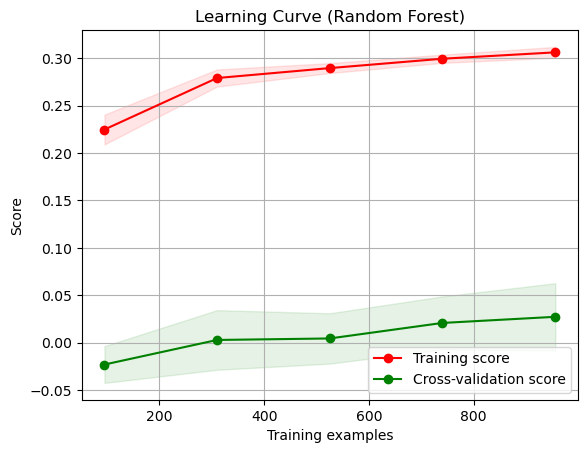

In [46]:
from sklearn.ensemble import RandomForestRegressor

# Assuming best_params_rf contains the best parameters found for RandomForestRegressor from previous steps
best_rf = RandomForestRegressor(**best_params_rf, random_state=42)

# Fit the model on the training data
best_rf.fit(X_train, y_train)

# Plot learning curve for RandomForestRegressor
title = "Learning Curve (Random Forest)"
plot_learning_curve(best_rf, title, X_train, y_train, cv=5, n_jobs=-1)
plt.show()



In [55]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 349.9 kB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [56]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

# Assuming best_params_dt contains the best parameters found for the DecisionTreeRegressor
# And best_params_rf contains the best parameters for the RandomForestRegressor

# Instantiate base models with the best parameters
dt_reg_best = DecisionTreeRegressor(**random_search_dt.best_params_)
rf_reg_best = RandomForestRegressor(**best_params_rf)

# Define the base models list
base_models = [
    ('decision_tree_best', dt_reg_best),
    ('random_forest_best', rf_reg_best)
]

# Choose a meta-learner
catboost_meta_learner = CatBoostRegressor(iterations=100, 
                                          learning_rate=0.1, 
                                          depth=2, 
                                          verbose=False, 
                                          random_state=42)

# Initialize the Stacking Regressor
stack_reg = StackingRegressor(estimators=base_models, 
                              final_estimator=catboost_meta_learner, 
                              cv=5)

# Now you can fit the stacking ensemble to your training data and use it for predictions
stack_reg.fit(X_train, y_train)

# And proceed with predictions, evaluation, etc.


StackingRegressor(cv=5,
                  estimators=[('decision_tree_best',
                               DecisionTreeRegressor(max_depth=2,
                                                     max_features='log2',
                                                     min_samples_leaf=13,
                                                     min_samples_split=4)),
                              ('random_forest_best',
                               RandomForestRegressor(max_depth=16,
                                                     max_features='log2',
                                                     min_samples_leaf=10,
                                                     min_samples_split=10,
                                                     n_estimators=445))],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x16764c990>)

In [57]:
y_pred = stack_reg.predict(X_valid)


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R^2 score): {r2}")


Mean Absolute Error (MAE): 0.5831277248679256
Mean Squared Error (MSE): 0.8969992916951546
Coefficient of Determination (R^2 score): -0.013401913586384762
